### Importing modules

In [1]:
import numpy as np                    
import pandas as pd                   
import matplotlib.pyplot as plt  
import warnings      
from isoweek import Week    
from sklearn import preprocessing    
import statsmodels.api as sm      
from sklearn.model_selection import train_test_split  
from sklearn import metrics
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn import tree
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Defining functions

### Function 1:  Adding promotion details to data

In [2]:
def add_promotions(df1, df2):
    
    temp = pd.merge(df1, df2, on = ["SKU","ISO_Week"], how = "outer", indicator=True)
    temp["Promo_indicator"] = np.nan
    for i in range(len(temp)):
        if temp["_merge"][i] == "both":
            temp["Promo_indicator"][i] = "Yes"
        else:
            temp["Promo_indicator"][i] = "No"
    
    temp.drop(columns = ["Weeks","_merge"], axis = 1, inplace = True)
    
    return temp

### Function 2: Removing outliers using IQR

In [3]:
def remove_outliers(df, col):
    
    perc_25 = np.percentile(df[col], 25)
    perc_75 = np.percentile(df[col], 75)
    iqr = perc_75 - perc_25
    ll = perc_25 - 1.5*iqr
    ul = perc_75 + 1.5*iqr
    
    print("\n IQR {} \n Lower limit {}\n Upper limit {}".format(iqr, ll, ul))
    print("\n Minimum {} \n Maximum {} \n".format(min(df[col]), max(df[col])))
    
    if min(df[col]) < ll and max(df[col]) > ul:
        print("There are samples which violate both upper limit and lower limit")
        idx = np.where((df[col] < ll) and (df[col] > ul))
        df.drop(idx[0], inplace = True)
        print("Outliers have been removed")

    elif min(df[col]) < ll and max(df[col]) <= ul:
        print("There are samples which violate only lower limit")
        idx = np.where(df[col] < ll)
        df.drop(idx[0], inplace = True)
        print("Outliers have been removed")
    
    elif min(df[col]) >= ll and max(df[col]) > ul:
        print("There are samples which violate only upper limit")
        idx = np.where(df[col] > ul)
        df.drop(idx[0], inplace = True)
        print("Outliers have been removed")
        
    df = df.reset_index()
    df.drop(columns=["index"], axis=1, inplace = True)
    
    return df

### Function 3: Dropping rows

In [4]:
def drop_rows(df, key_word):
    
    if key_word == 'NaNs':
        df.dropna(inplace = True)
        print("Number of samples after dropping NaNs :",df.shape)
    elif key_word == 'duplicates':
        df.drop_duplicates(inplace = True)
        print("Number of samples after dropping duplicates :",df.shape)
    elif key_word == 'zeros':
        df = df[df.Sales != 0]
        print("Number of samples after dropping Sales value 0 :",df.shape)
    else:
        print("Please specify correct key-word")
        
    df = df.reset_index()
    df.drop(["index"], axis = 1, inplace = True)
    
    return df

### Function 4: Converting from ISO week to month 

In [5]:
def isoweek_to_month(df):
    
    month_dict = {1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sep', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}
    df["Start_Month"] = np.nan
    df["Start_Month_num"] = np.nan
    
    temp = pd.DataFrame(list(df["ISO_Week"].str.split("-")))
    temp.columns = ["ISO_Y", "ISO_W"]
    
    for i in range(temp.shape[0]):
        first_day = Week(int(temp["ISO_Y"][i]), int(temp["ISO_W"][i])).monday()
        month_num = first_day.month
        month_name = month_dict[month_num] 
        df["Start_Month"][i] = month_name
        df["Start_Month_num"][i] = month_num
          
    return df   

### Function 5: Encoding categorical variables

In [6]:
def categorical_encode(df, col, key_word):
    
    if key_word == 'l_encode':
        le = preprocessing.LabelEncoder() 
        l_encodes = pd.DataFrame(le.fit_transform(df[col]))
        l_encodes.columns = [col + "_encoded"]
        df = pd.concat([df, l_encodes], axis = 1)
        df.drop([col], axis = 1, inplace = True)
    
    elif key_word == 'o_encode':
        o_encodes = pd.get_dummies(df[col]).astype(int)
        df = pd.concat([df, o_encodes], axis = 1)
        df.drop([col], axis = 1, inplace = True)
    
    else:
        print("Please specify correct key-word")
        
    return df 

### Function 6: Observing error for different training sample size

In [7]:
def error_vs_sample_size(df_tr_X, df_tr_Y, df_tt_X, df_tt_Y, model):
    
    tr_error = []
    val_error = []
    tt_error = []
    train_sample_size = []
    
    test_size = [0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1]
    
    for i in range(len(test_size)):
        x_train, x_val, y_train, y_val = train_test_split(df_tr_X, df_tr_Y, test_size=test_size[i], random_state=7)
        model.fit(x_train, y_train)
        
        pred_tr = model.predict(x_train)
        pred_val = model.predict(x_val)
        pred_tt = model.predict(df_tt_X)
        
        tr_error.append(metrics.mean_absolute_error(y_train, pred_tr))
        val_error.append(metrics.mean_absolute_error(y_val, pred_val))
        tt_error.append(metrics.mean_absolute_error(df_tt_Y, pred_tt))
        
        train_sample_size.append((1-test_size[i])*df_tr_X.shape[0])
    
    res = pd.concat([pd.DataFrame(train_sample_size), pd.DataFrame(tr_error), pd.DataFrame(val_error), pd.DataFrame(tt_error)], axis = 1)
    res.columns = ["Training sample size", "Train error", "Validation error", "Test error"]
    
    plt.figure(figsize = (10,7))
    plt.plot(res["Training sample size"], res["Train error"], label = 'Train error', marker='o')
    plt.plot(res["Training sample size"], res["Validation error"], label = 'Validation error', marker='o')
    plt.plot(res["Training sample size"], res["Test error"], label = 'Test error', marker='o')
    plt.legend()
    plt.title("Errors per training sample size")
    plt.xlabel("Training sample size")
    plt.ylabel("MAE Error")
    plt.show()

### Function 7: Modelling

In [8]:
def modelling(df_tr_X, df_tr_Y, df_tt_X, df_tt_Y, model):
    
    model.fit(df_tr_X, df_tr_Y)
    
    pred_tr = model.predict(df_tr_X)
    pred_tt = model.predict(df_tt_X)
    
    print("Train error (MAE): ",metrics.mean_absolute_error(df_tr_Y, pred_tr))
    print("Test error (MAE): ",metrics.mean_absolute_error(df_tt_Y, pred_tt))
    print("R-squared value :", r2_score(df_tt_Y, pred_tt))
    
    plt.figure(figsize = (10,7))
    plt.plot(df_tr_Y, label = 'Train original', marker='o')
    plt.plot(pred_tr, label = 'Train predicted', marker='o')
    plt.title("Learning on train data")
    plt.xlabel("Number of training samples")
    plt.ylabel("Sales")
    plt.legend()
    plt.show()
    
    plt.figure(figsize = (10,7))
    plt.plot(df_tt_Y, label = 'Test original', marker='o')
    plt.plot(pred_tt, label = 'Test predicted', marker='o')
    plt.title("Learning on test data")
    plt.xlabel("Number of testing samples")
    plt.ylabel("Sales")
    plt.legend()
    plt.show()
    
    res = pd.concat([pd.DataFrame(df_tt_Y), pd.DataFrame(pred_tt)], axis = 1)
    res.columns = ['Sales original','Sales predicted']
    
    return res

### Function 8: Visualisations

In [9]:
def box_plot(df, key_word, size1, size2, grp_by, group_indicator):
    
    if group_indicator == 0:
        df.boxplot(column=[key_word], figsize=(size1,size2))
        plt.title("Distribution of " + key_word)
        plt.ylabel(key_word)
        plt.xticks(rotation=90)
        plt.show()
    else:
        df.boxplot(column=[key_word], by=grp_by, figsize=(size1,size2))
        plt.title("Distribution of " + key_word)
        plt.ylabel(key_word)
        plt.xticks(rotation=90)
        plt.show()

### Defining path and loading data

In [10]:
path = "/Users/sohinimitra/Documents/EY/"

data = pd.read_excel(path + "case_study.xlsx", sheet_name = "Sales")
promotions = pd.read_excel(path + "Promotions.xlsx")
promotions["ISO_Week"] = promotions["Weeks"].str.replace("\'","")

#### Note: Promotions data have been extracted from the case study document. 

In [11]:
data.sample(3)

,SKU,ISO_Week,Sales,Season
21,ProductA,2018-20,10470.0,SPRING
14,ProductA,2018-14,10378.0,SPRING
103,ProductB,2018-49,489.0,WINTER


In [12]:
promotions.sample(3)

,SKU,Weeks,ISO_Week
16,ProductA,2018-52',2018-52
3,ProductA,2018-14',2018-14
22,ProductC,2018-26',2018-26


### Adding promotions and month inforamtion to data

In [13]:
data = add_promotions(data, promotions)
data = isoweek_to_month(data)
data.sample(3)

,SKU,ISO_Week,Sales,Season,Promo_indicator,Start_Month,Start_Month_num
136,ProductC,2018-39,4357.0,AUTUMN,No,Sep,9.0
145,ProductC,2018-48,12927.0,AUTUMN,Yes,Nov,11.0
97,ProductB,2018-43,0.0,AUTUMN,No,Oct,10.0


### Observing overview of data

In [14]:
print("Number of samples and columns in dataset :", data.shape)
print("Information about NULLs in dataset :\n")
data.info()

Number of samples and columns in dataset : (150, 7)
Information about NULLs in dataset :

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 7 columns):
SKU                150 non-null object
ISO_Week           150 non-null object
Sales              143 non-null float64
Season             150 non-null object
Promo_indicator    150 non-null object
Start_Month        150 non-null object
Start_Month_num    150 non-null float64
dtypes: float64(2), object(5)
memory usage: 14.4+ KB


#### Note: <br> i. There are NULL values in Sales column <br> ii. Most features are categorical in nature

### Removing NaNs, duplicates and zero-Sales rows

In [15]:
data = drop_rows(data, "NaNs")
data = drop_rows(data, "duplicates")
data = drop_rows(data, "zeros")

Number of samples after dropping NaNs : (143, 7)
Number of samples after dropping duplicates : (139, 7)
Number of samples after dropping Sales value 0 : (119, 7)


### Removing outliers

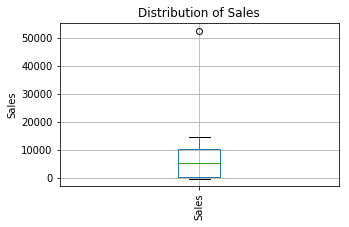


 IQR 10007.5 
 Lower limit -14549.75
 Upper limit 25480.25

 Minimum -163.0 
 Maximum 52524.0 

There are samples which violate only upper limit
Outliers have been removed


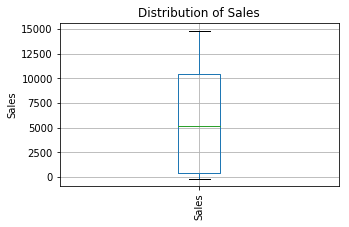

Number of samples and columns in dataset after removing outliers: (118, 7)


In [16]:
box_plot(data, "Sales", 5, 3, None, 0)
data = remove_outliers(data, "Sales")
box_plot(data, "Sales", 5, 3, None, 0)
print("Number of samples and columns in dataset after removing outliers:", data.shape)

### Observing overview of categorical data

In [17]:
print("Summary of categorical columns in dataset :\n")
data.describe(include = ['O'])

Summary of categorical columns in dataset :



,SKU,ISO_Week,Season,Promo_indicator,Start_Month
count,118,118,118,118,118
unique,3,48,4,2,12
top,ProductA,2018-38,AUTUMN,No,Dec
freq,45,3,34,78,12


#### Note: Maximum number of data points at ISO_Week level is 3. There is not much information at week level.

### Observing overview of numerical data

In [18]:
print("Summary of numerical columns in dataset :\n")
data.describe()

Summary of numerical columns in dataset :



,Sales,Start_Month_num
count,118.000000,118.000000
mean,5760.440678,7.101695
std,4680.679678,3.267006
min,-163.000000,1.000000
25%,460.250000,4.250000
50%,5171.000000,7.000000
75%,10453.500000,10.000000
max,14853.000000,12.000000


### Visualisations

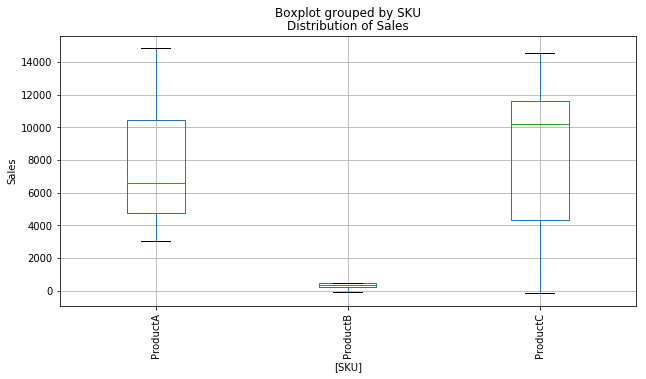

In [19]:
box_plot(data, "Sales", 10, 5, ['SKU'], 1)

#### Note: Sales for ProductB is at a lower scale compared to ProductA and ProductC

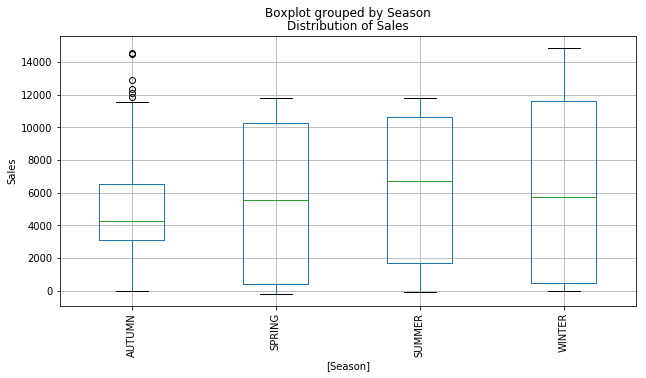

In [20]:
box_plot(data, "Sales", 10, 5, ['Season'], 1)

#### Note: Average Sales during SUMMER and WINTER are higher compared to other seasons

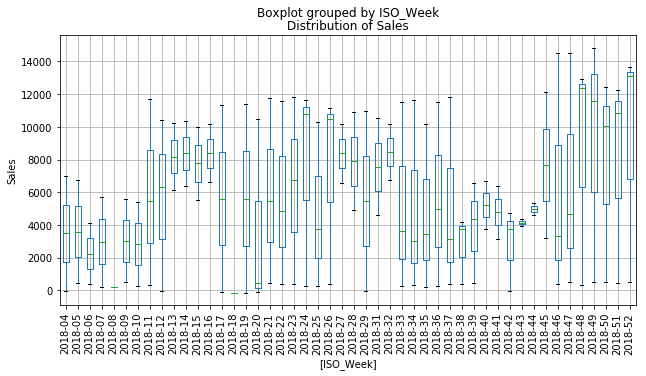

In [21]:
box_plot(data, "Sales", 10, 5, ['ISO_Week'], 1)

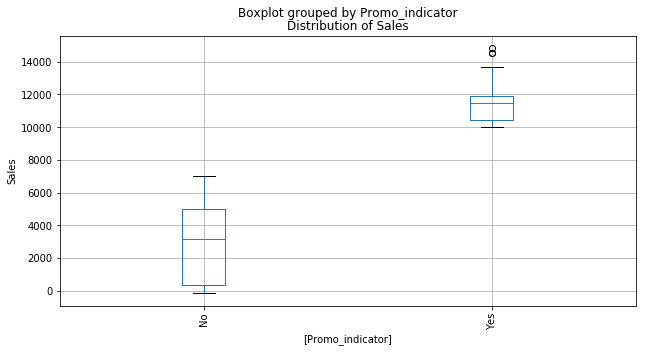

In [22]:
box_plot(data, "Sales", 10, 5, ['Promo_indicator'], 1)

#### Note: Sales during promotions is much higher compared to non-promotions sales

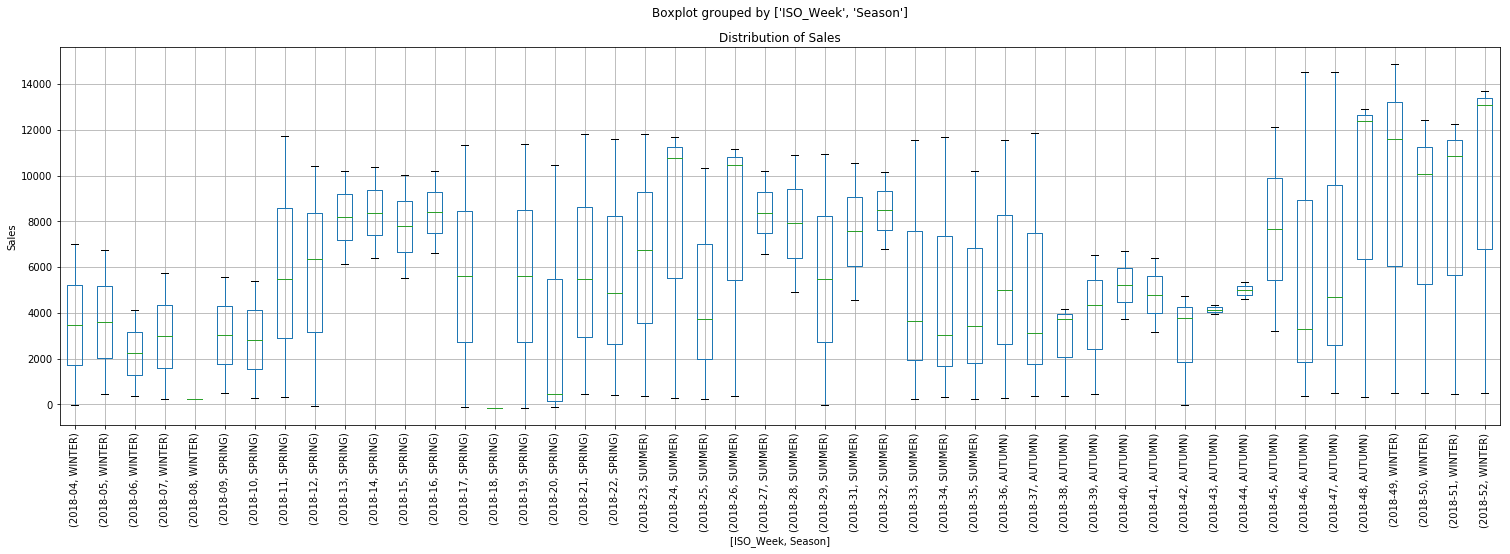

In [23]:
box_plot(data, "Sales", 25, 7, ['ISO_Week', 'Season'], 1)

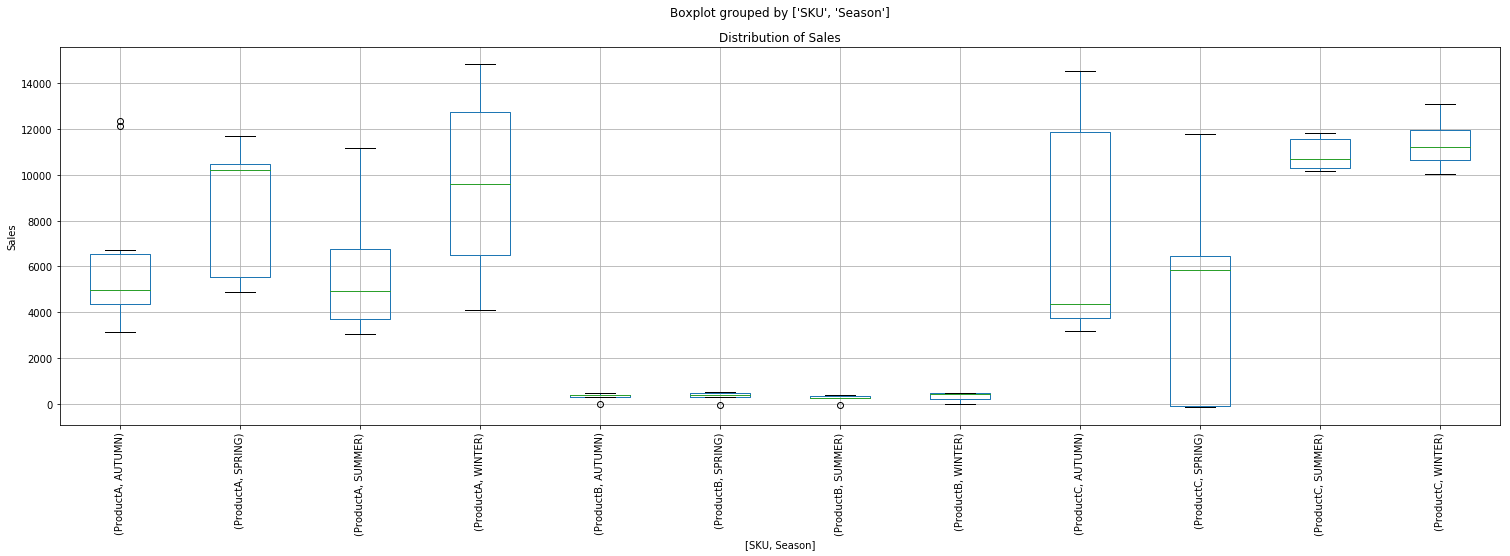

In [24]:
box_plot(data, "Sales", 25, 7, ['SKU', 'Season'], 1)

#### Note: Sales of products across different seasons can be observed 

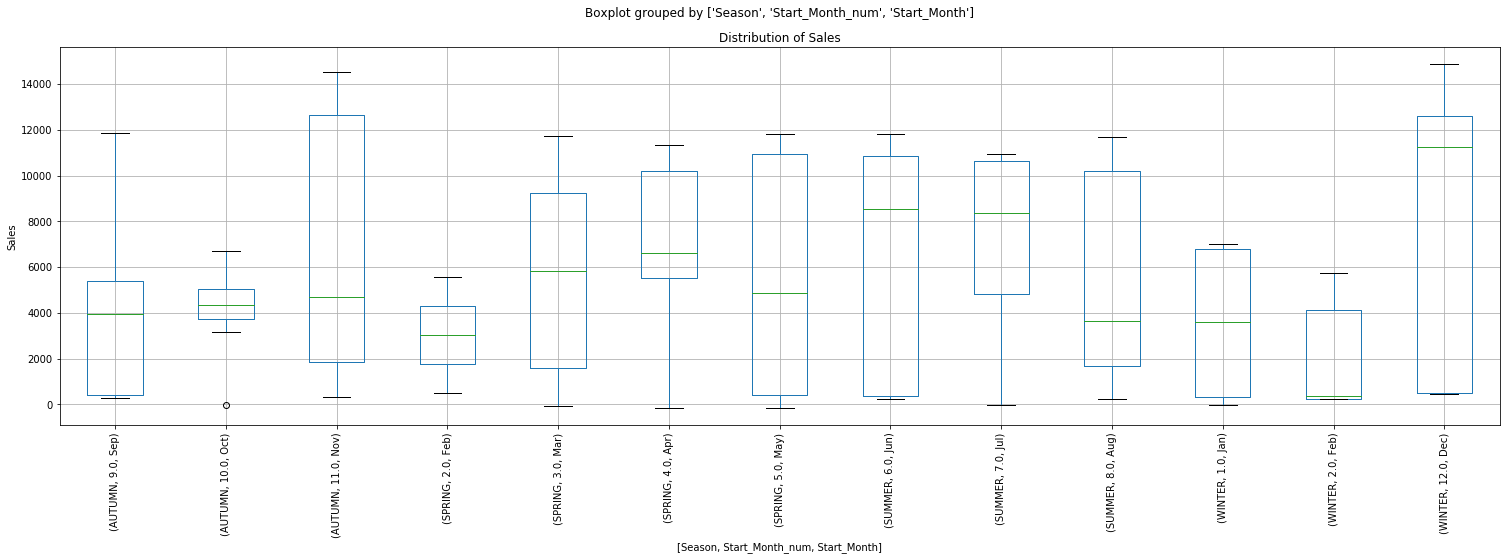

In [25]:
box_plot(data, "Sales", 25, 7, ['Season','Start_Month_num','Start_Month'], 1)

#### Note: Seasons have been mapped to months

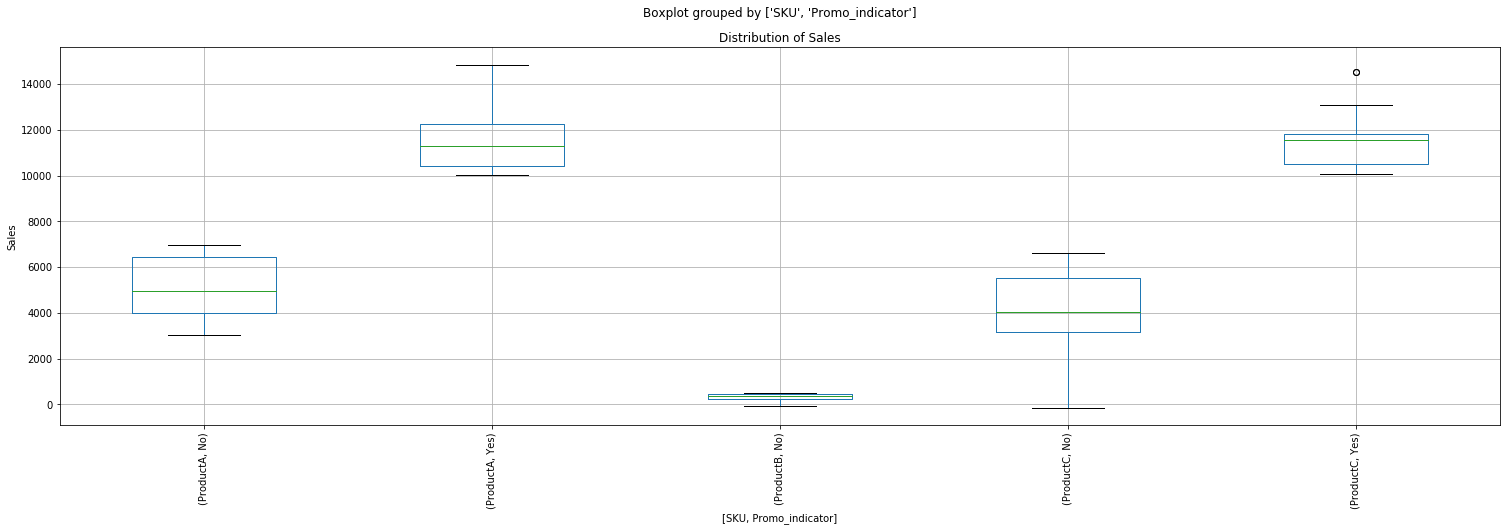

In [26]:
box_plot(data, "Sales", 25, 7, ['SKU', 'Promo_indicator'], 1)

#### Note: <br> i. Effect of promotions on Sales across different products <br> ii. ProductB has no promotions (accounts for its lower sales)

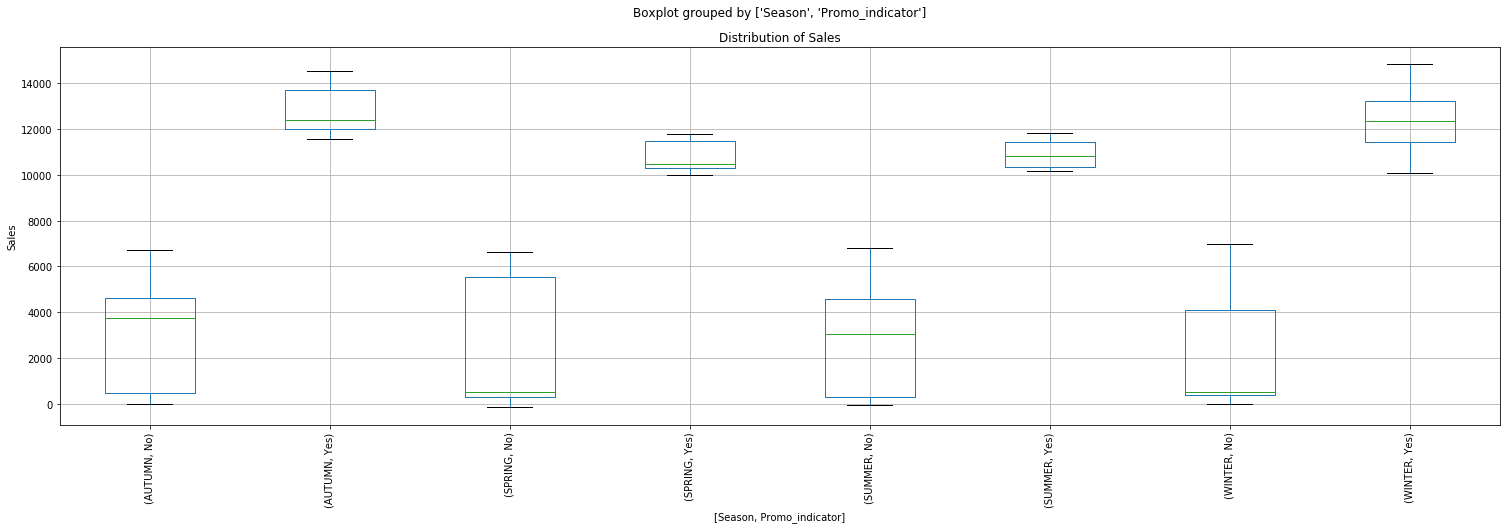

In [27]:
box_plot(data, "Sales", 25, 7, ['Season', 'Promo_indicator'], 1)

#### Note: Winter promotions acquire more Sales

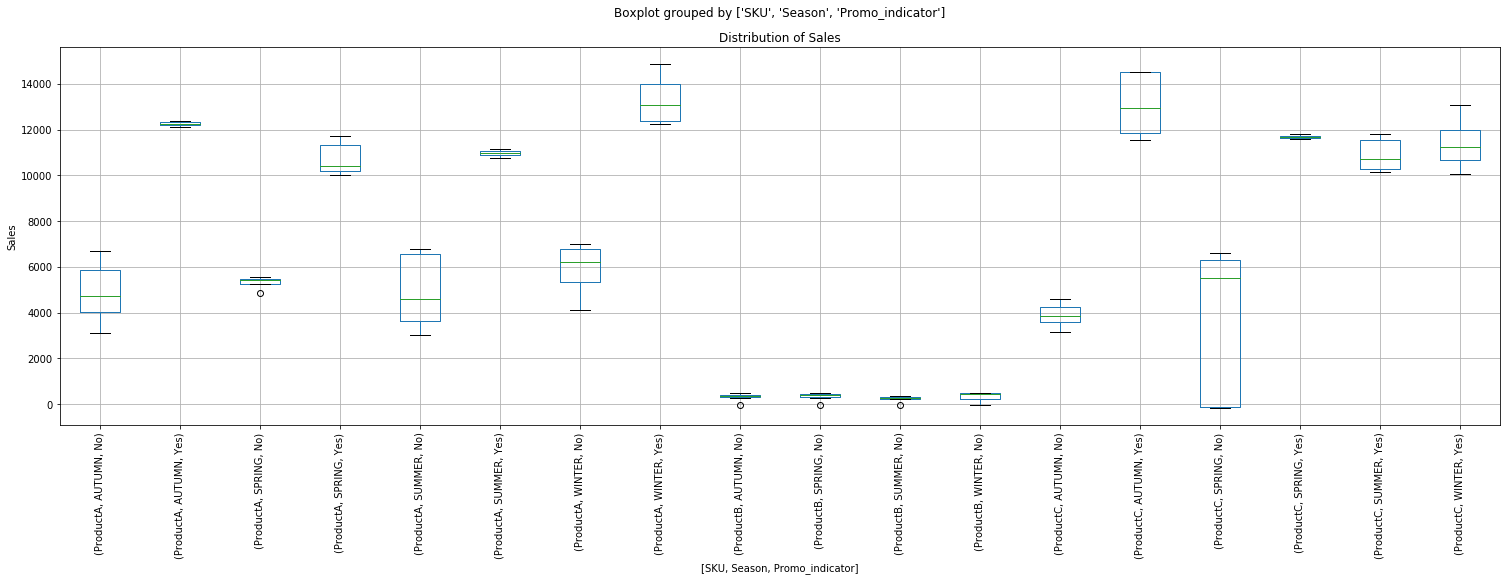

In [28]:
box_plot(data, "Sales", 25, 7, ['SKU', 'Season', 'Promo_indicator'], 1)

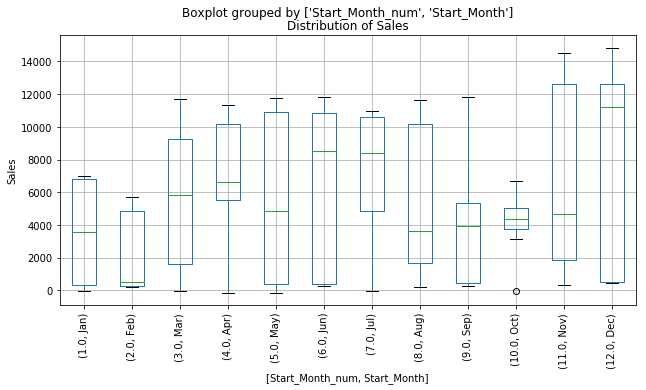

In [29]:
box_plot(data, "Sales", 10, 5, ['Start_Month_num','Start_Month'], 1)

#### Note: Monthly Sales can be observed

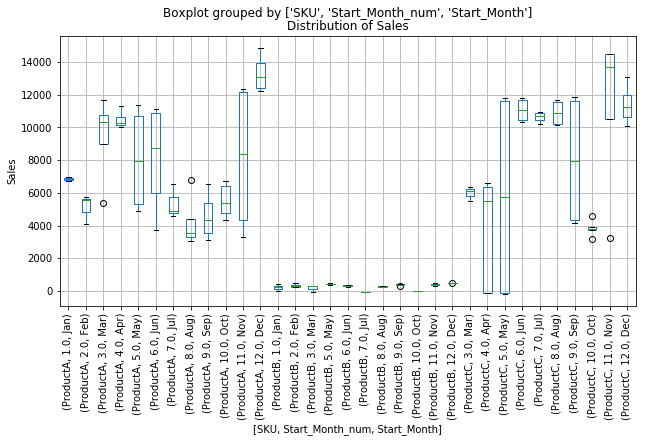

In [30]:
box_plot(data, "Sales", 10, 5, ['SKU','Start_Month_num','Start_Month'], 1)

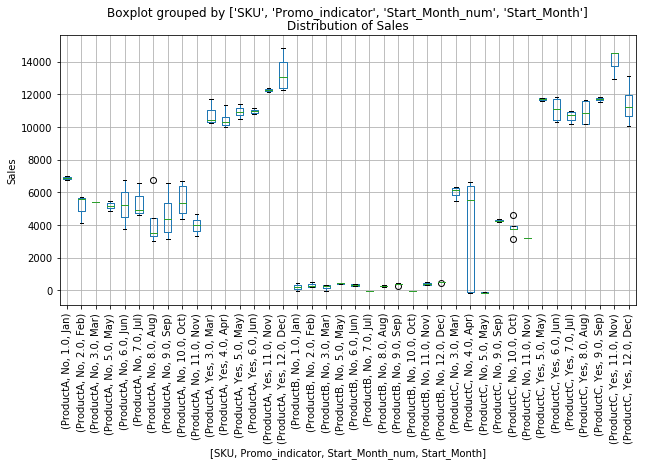

In [31]:
box_plot(data, "Sales", 10, 5, ['SKU','Promo_indicator','Start_Month_num','Start_Month'], 1)

### Encoding categorical variables

In [32]:
df = data.sort_values(by=['ISO_Week'])

df = categorical_encode(df, 'Promo_indicator' ,'l_encode')
df = categorical_encode(df, 'SKU' ,'o_encode')
df = categorical_encode(df, 'Start_Month' ,'o_encode')
df = categorical_encode(df, 'Season' ,'o_encode')
df = categorical_encode(df, 'ISO_Week' ,'o_encode')

### Using Mutual Information for feature selection

In [33]:
features = df.drop(["Sales"], axis = 1)
target = df["Sales"]
MI = mutual_info_regression(np.array(features), np.array(target), discrete_features=True)
MI_data = pd.concat([pd.DataFrame(features.columns),pd.DataFrame(MI)], axis = 1)
MI_data.columns = ["Features", "Mutual Information"]
MI_data.sort_values(by = "Mutual Information", ascending = False)

,Features,Mutual Information
3,ProductB,5.886969e-01
0,Start_Month_num,2.330009e-01
2,ProductA,1.987652e-01
4,ProductC,1.799008e-01
18,SPRING,1.603524e-01
7,Dec,1.271387e-01
17,AUTUMN,6.592539e-02
1,Promo_indicator_encoded,6.059855e-02
15,Oct,5.160837e-02
20,WINTER,4.717870e-02


#### Note: <br> i. Products, Promotions, Month number and Season have high Mutual Information <br> ii. ISO_Weeks and Month name have low Mutual Information in general <br> iii. Lower Mutual Inforamtion features will be removed for modeling

### Preparing data for modeling

In [34]:
df = data[['ISO_Week','SKU','Season','Promo_indicator','Start_Month_num', 'Sales']]

df = categorical_encode(df, 'Promo_indicator' ,'l_encode')
df = categorical_encode(df, 'SKU' ,'o_encode')
df = categorical_encode(df, 'Season' ,'o_encode')

c = df.corr()
print("Correlation matrix :\n")
c

Correlation matrix :



,Start_Month_num,Sales,Promo_indicator_encoded,ProductA,ProductB,ProductC,AUTUMN,SPRING,SUMMER,WINTER
Start_Month_num,1.000000,0.162068,0.142712,-0.045997,-0.065946,0.108491,0.561064,-0.599177,-0.024579,0.060374
Sales,0.162068,1.000000,0.883744,0.294595,-0.712346,0.364579,-0.074361,-0.021722,0.079461,0.021866
Promo_indicator_encoded,0.142712,0.883744,1.000000,0.064346,-0.436826,0.342208,-0.178890,0.006143,0.142030,0.041253
ProductA,-0.045997,0.294595,0.064346,1.000000,-0.478928,-0.572917,0.001306,0.031263,-0.032588,-0.000387
ProductB,-0.065946,-0.712346,-0.436826,-0.478928,1.000000,-0.445115,-0.051364,-0.071948,-0.017619,0.164719
ProductC,0.108491,0.364579,0.342208,-0.572917,-0.445115,1.000000,0.046624,0.035284,0.049692,-0.153397
AUTUMN,0.561064,-0.074361,-0.178890,0.001306,-0.051364,0.046624,1.000000,-0.388084,-0.379770,-0.296022
SPRING,-0.599177,-0.021722,0.006143,0.031263,-0.071948,0.035284,-0.388084,1.000000,-0.364122,-0.283824
SUMMER,-0.024579,0.079461,0.142030,-0.032588,-0.017619,0.049692,-0.379770,-0.364122,1.000000,-0.277744
WINTER,0.060374,0.021866,0.041253,-0.000387,0.164719,-0.153397,-0.296022,-0.283824,-0.277744,1.000000


#### Note: Some features like Promotions, Products are strongly correlated to Sales. 

### Getting train and test data

In [35]:
df = df.sort_values(by=['ISO_Week'])

data_tr = df.loc[df["ISO_Week"]<='2018-41']
data_tt = df.loc[df["ISO_Week"]>'2018-41']

data_tr.drop(['ISO_Week'], axis = 1, inplace = True)
data_tt.drop(['ISO_Week'], axis = 1, inplace = True)

data_tr = data_tr.reset_index()
data_tr.drop(["index"], axis = 1, inplace = True)
data_tt = data_tt.reset_index()
data_tt.drop(["index"], axis = 1, inplace = True)


data_tr_X = data_tr.drop(["Sales"], axis = 1)
data_tr_Y = data_tr["Sales"]

data_tt_X = data_tt.drop(["Sales"], axis = 1)
data_tt_Y = data_tt["Sales"]

### Modeling 1: Using linear model, accounting to some strong correlations

In [36]:
#data_tr_X = sm.add_constant(data_tr_X)
#ata_tt_X = sm.add_constant(data_tt_X)

model = sm.OLS(data_tr_Y, data_tr_X)
results = model.fit()
print(results.summary())
#print(results.params)
pred = results.predict(data_tt_X)
x = pd.concat([pd.DataFrame(data_tt_Y), pd.DataFrame(pred)], axis = 1)
print("\n\n")
print("Train error (MAE): ",metrics.mean_absolute_error(data_tr_Y, results.predict(data_tr_X)))
print("Test error (MAE): ",metrics.mean_absolute_error(data_tt_Y, pred))

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     115.2
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           4.43e-39
Time:                        16:54:58   Log-Likelihood:                -755.63
No. Observations:                  88   AIC:                             1527.
Df Residuals:                      80   BIC:                             1547.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Start_Month_num          -

#### Note: R-squared value is good. The model is able to capture 90% of the variance in data. However, test error is high. This observation could be accounted to some of the weakly correlated features.

###  Modeling 2: Using decison tree

In [37]:
model = DecisionTreeRegressor(random_state=10, criterion = 'mae', max_depth = 3)

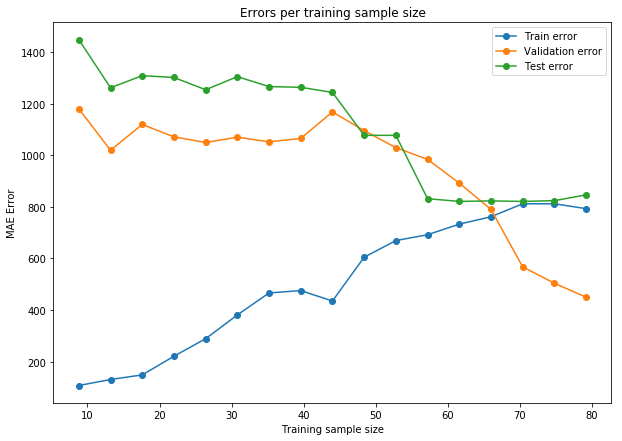

In [38]:
error_vs_sample_size(data_tr_X, data_tr_Y, data_tt_X, data_tt_Y, model)

#### Note: As the sample size increases, test error reduces. More data can help learning.

Train error (MAE):  757.1363636363636
Test error (MAE):  850.9333333333333
R-squared value : 0.9469896776577937


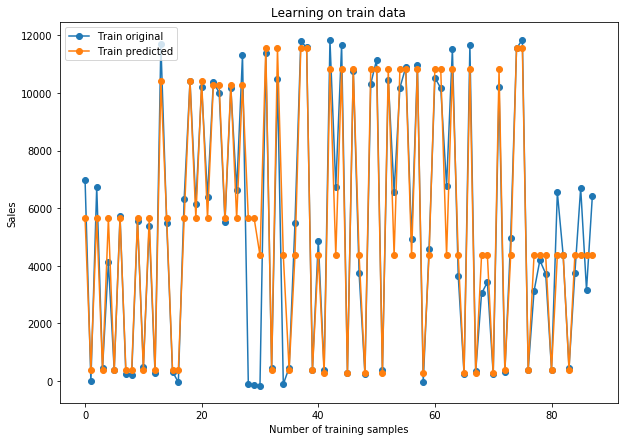

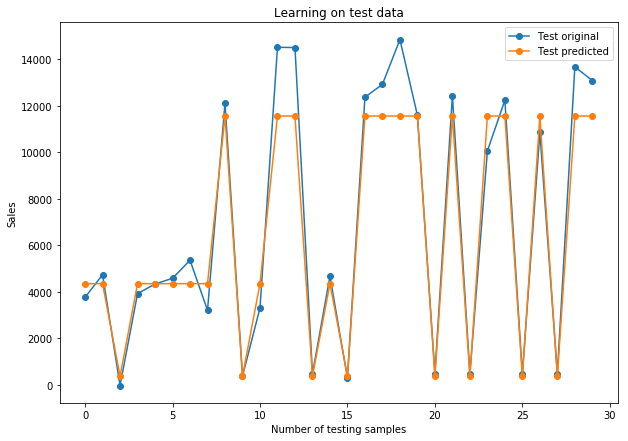

In [39]:
r = modelling(data_tr_X, data_tr_Y, data_tt_X, data_tt_Y, model)

#### Note: Both train and test errors have reduced significantly from linear model. R-squared value has also improved. The original and predicted sales in train and test data can be observed. 

### Preparing result format

In [40]:
res = data[["SKU", "ISO_Week", "Sales"]]
res = res.sort_values(by=['ISO_Week'])
res = res.loc[res["ISO_Week"]>'2018-41']
res_f = pd.merge(res, r, left_on = "Sales", right_on = "Sales original", how = "inner")
res_f.drop(['Sales', 'Sales original'], axis = 1, inplace = True)
res_f.rename({'Sales predicted':'Forecast'}, axis = 1, inplace = True)
res_f = res_f.sort_values(by = ['SKU','ISO_Week'])
res_f = res_f.reset_index()
res_f.drop(['index'], axis = 1, inplace = True)
res_f

,SKU,ISO_Week,Forecast
0,ProductA,2018-42,4357.0
1,ProductA,2018-43,4357.0
2,ProductA,2018-44,4357.0
3,ProductA,2018-45,11566.0
4,ProductA,2018-46,4357.0
5,ProductA,2018-47,4357.0
6,ProductA,2018-48,11566.0
7,ProductA,2018-49,11566.0
8,ProductA,2018-50,11566.0
9,ProductA,2018-51,11566.0


### Saving results

In [41]:
#res_f.to_excel("Nov20-EY-forecast.xlsx")